## Data Preprocessing:

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [3]:
train_start_date = '2000-01-01'
train_end_date = '2014-01-01'
test_start_date = '2014-01-01'
test_end_date = '2019-01-01'
regime_threshold = 2

In [4]:
spx = yf.download('^GSPC', start='2000-01-01', interval='1mo')
vix = yf.download('^VIX', start='2000-01-01', interval='1mo')
cpi = pd.read_csv('cpi.csv')
gdp = pd.read_csv('GDP.csv')
unemployment = pd.read_csv('UNRATE.csv')
ff = pd.read_csv('FF.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
gdp['observation_date'] = pd.to_datetime(gdp['observation_date'])
gdp.set_index('observation_date', inplace=True)
gdp = gdp.apply(pd.to_numeric, errors='coerce')
gdp = gdp.resample('MS').mean()
gdp = gdp.interpolate(method='linear')
gdp['GDP pct change'] =  (gdp['GDP'].shift(-1) / gdp['GDP'] - 1) * 100

cpi['observation_date'] = pd.to_datetime(cpi['observation_date'])
cpi.set_index('observation_date', inplace=True)

unemployment['observation_date'] = pd.to_datetime(unemployment['observation_date'])
unemployment.set_index('observation_date', inplace=True)

spx['pct_chg'] = (spx['Close']/spx['Open'] - 1) * 100

vix['pct_chg'] = (vix['Close']/vix['Open'] - 1) * 100

ff['Unnamed: 0'] = pd.to_datetime(ff['Unnamed: 0'].astype(str), format='%Y%m')
ff.set_index('Unnamed: 0', inplace=True)

In [6]:
macro = cpi.join(gdp['GDP pct change'], how='inner')
macro = macro.join(unemployment, how='inner')
macro = macro.join(ff, how = 'inner')
macro = macro.loc[train_start_date:test_end_date].copy()

def relabel(row):
    score = 0

    if row['Mkt-RF'] > 2:
        score += 1
    elif row['Mkt-RF'] < -2:
        score -= 1

    if row['GDP pct change'] > 2:
        score += 1
    elif row['GDP pct change'] < 0:
        score -= 1

    if row['UNRATE'] < 4:
        score += 1
    elif row['UNRATE'] > 6:
        score -= 1

    if score >= 2:
        return 0  
    elif score <= -1:
        return 2  
    else:
        return 1  

macro['regime'] = macro.apply(relabel, axis=1)

macro['target'] = macro['regime'].shift(-1)
macro = macro.dropna()


In [7]:
columns_to_scale = [col for col in macro.columns if col not in ['target', 'regime']]


scaler = MinMaxScaler()
factors_scaled = macro.copy()  
factors_scaled[columns_to_scale] = scaler.fit_transform(macro[columns_to_scale])

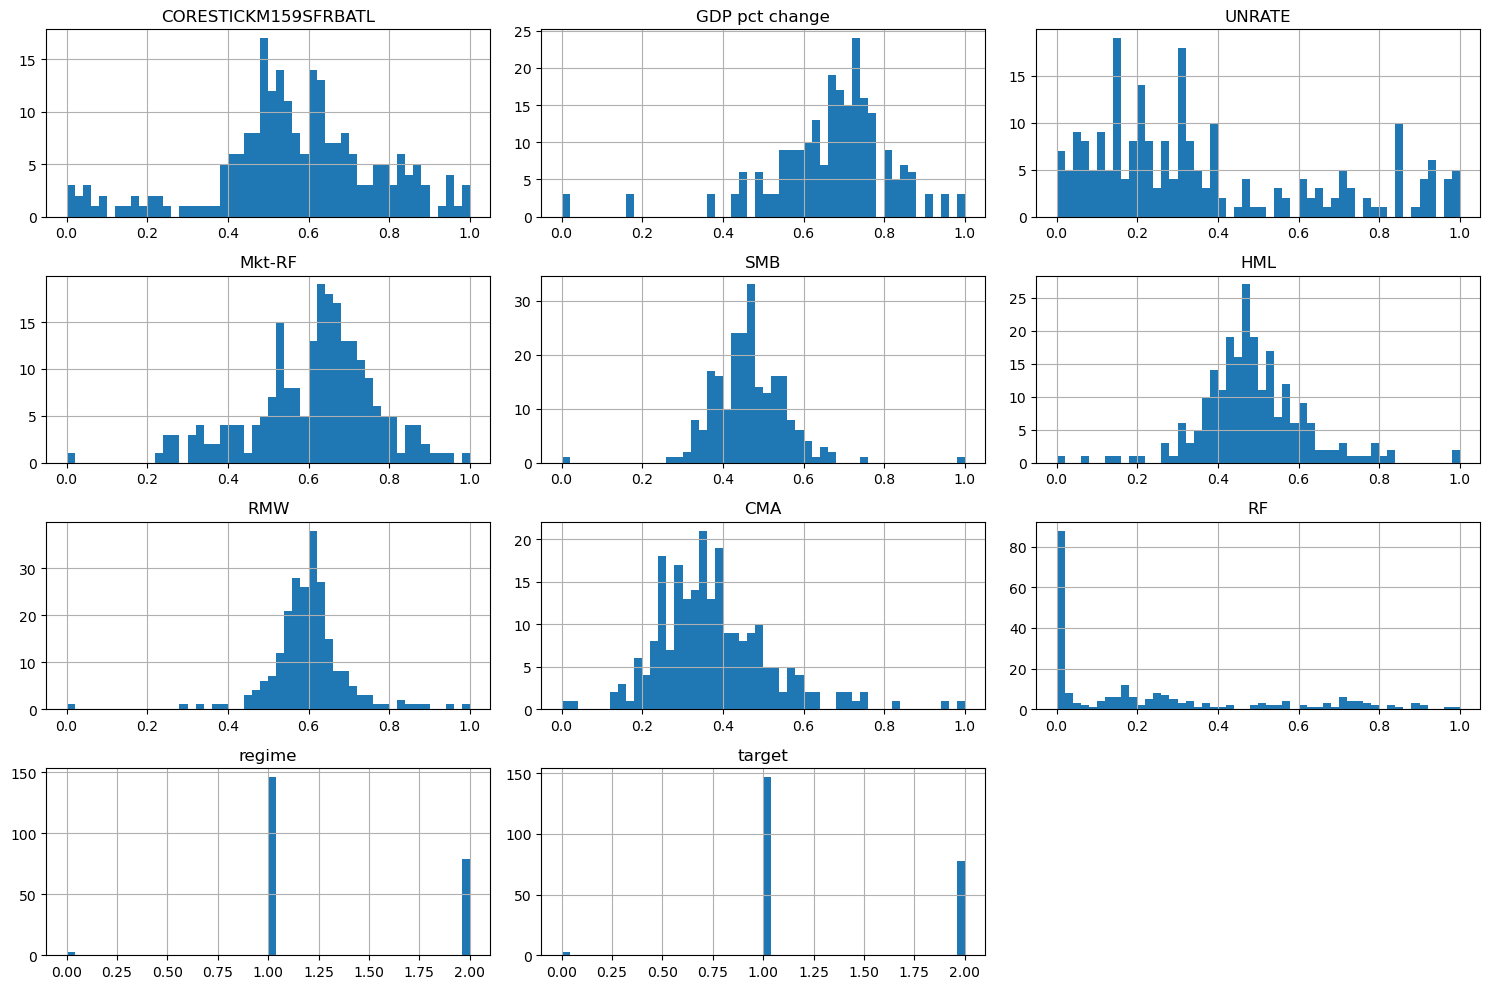

In [8]:
factors_scaled.hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

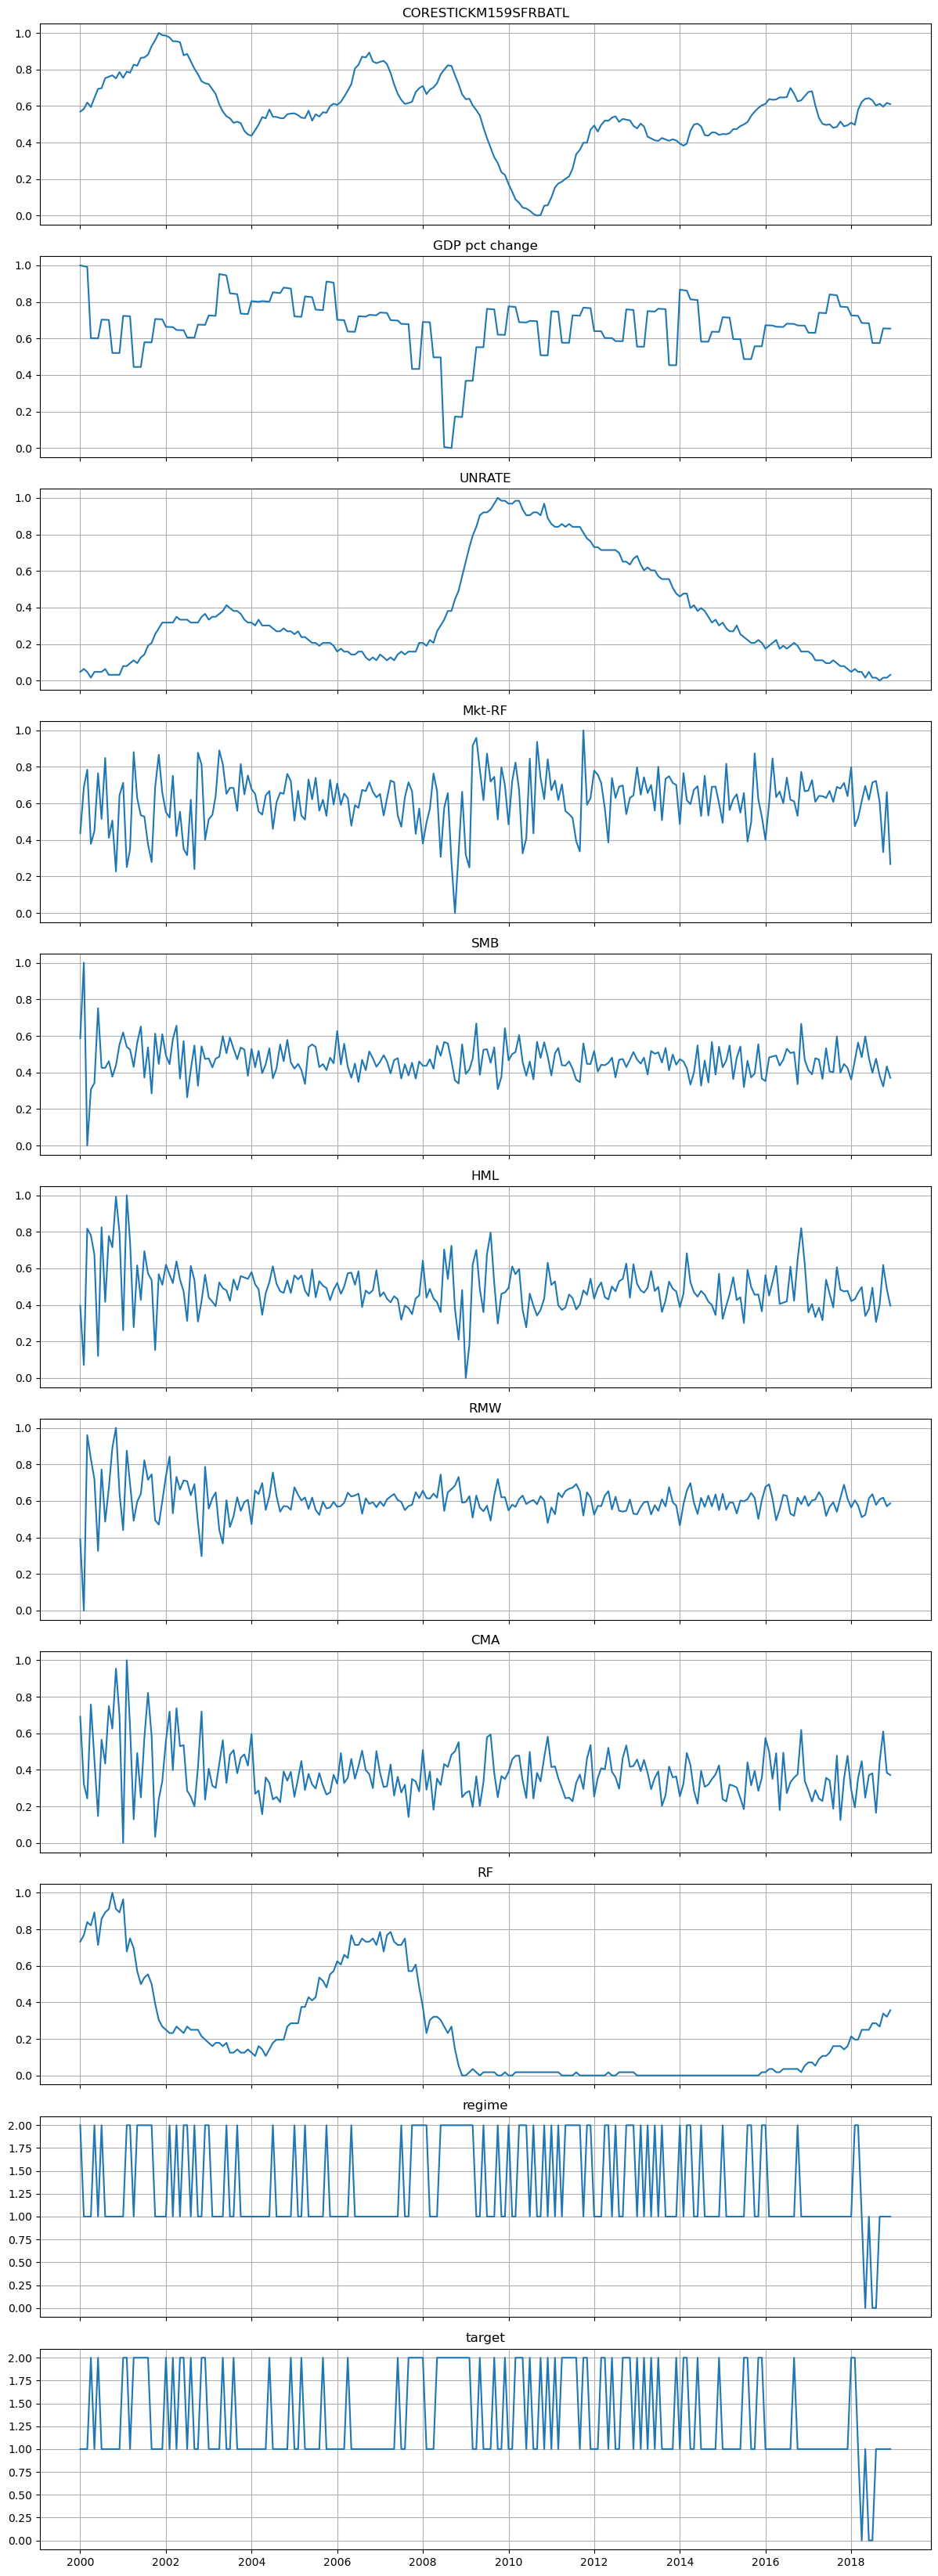

In [9]:
columns = factors_scaled.columns
num_columns = len(columns)

fig, axes = plt.subplots(num_columns, 1, figsize=(12, 3 * num_columns), sharex=True)

for i, col in enumerate(columns):
    axes[i].plot(factors_scaled.index, factors_scaled[col])
    axes[i].set_title(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [10]:
print(factors_scaled['target'].value_counts())

target
1.0    147
2.0     78
0.0      3
Name: count, dtype: int64


In [11]:
train = factors_scaled.loc[train_start_date:train_end_date].copy()
test = factors_scaled.loc[test_start_date:test_end_date].copy()

## Regime Labeling

[I 2025-04-09 20:46:22,010] A new study created in memory with name: no-name-d69aabff-f125-495b-8783-661b82945310


Class weights: {1.0: 1.5510204081632653, 2.0: 2.923076923076923, 0.0: 76.0}


[I 2025-04-09 20:46:23,481] Trial 0 finished with value: 0.34173913043478266 and parameters: {'learning_rate': 0.0914660540581278, 'n_estimators': 443, 'max_depth': 4, 'subsample': 0.8739702852629079, 'colsample_bytree': 0.5982699137812066, 'reg_alpha': 0.00011133464324634684, 'reg_lambda': 1.6389928645467282e-05, 'gamma': 3.474438865148184, 'min_child_weight': 10}. Best is trial 0 with value: 0.34173913043478266.
[I 2025-04-09 20:46:24,213] Trial 1 finished with value: 0.3067632850241545 and parameters: {'learning_rate': 0.10729835663541165, 'n_estimators': 207, 'max_depth': 4, 'subsample': 0.7575928921713937, 'colsample_bytree': 0.9671568693221329, 'reg_alpha': 0.0005035290569715288, 'reg_lambda': 2.099041080188389e-08, 'gamma': 1.9261550461629056, 'min_child_weight': 4}. Best is trial 1 with value: 0.3067632850241545.
[I 2025-04-09 20:46:25,885] Trial 2 finished with value: 0.337584541062802 and parameters: {'learning_rate': 0.1420806169619521, 'n_estimators': 386, 'max_depth': 5, '

Best trial:
  Accuracy: 0.7154
  Best hyperparameters: {'learning_rate': 0.1637663391347919, 'n_estimators': 507, 'max_depth': 4, 'subsample': 0.6553944139252451, 'colsample_bytree': 0.5972318854855386, 'reg_alpha': 8.343759389965159e-05, 'reg_lambda': 6.099905640823951e-06, 'gamma': 2.3745206611853167, 'min_child_weight': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.76      0.92      0.83       147
         2.0       0.76      0.50      0.60        78

    accuracy                           0.76       228
   macro avg       0.51      0.47      0.48       228
weighted avg       0.75      0.76      0.74       228



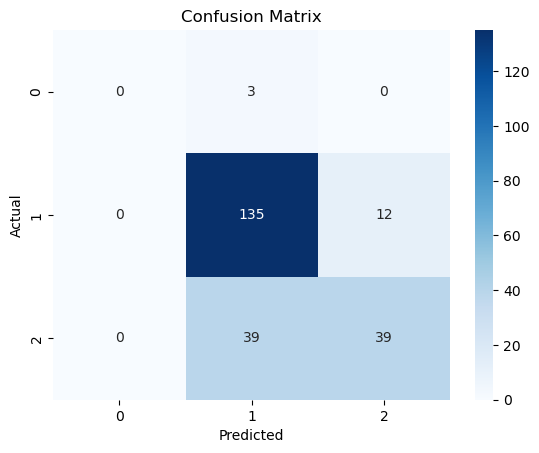

In [13]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')


features = ['UNRATE', 'Mkt-RF', 'CORESTICKM159SFRBATL', 'GDP pct change']
X = factors_scaled[features]
y = factors_scaled['target']

class_counts = y.value_counts().to_dict()
total = sum(class_counts.values())
class_weights = {cls: total/count for cls, count in class_counts.items()}

print("Class weights:", class_weights)

def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'auto',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

        preds = model.predict(X_valid)
        acc = accuracy_score(y_valid, preds)
        scores.append(acc)

    return 1.0 - np.mean(scores)  # Minimize error

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {1.0 - trial.value:.4f}")
print("  Best hyperparameters:", trial.params)

# Train final model on full data
best_params = trial.params
best_params.update({'objective': 'multi:softprob', 'num_class': 3, 'use_label_encoder': False, 'eval_metric': 'mlogloss'})

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

# Optional: Evaluate on full data
preds = final_model.predict(X)
print(classification_report(y, preds))

# Confusion matrix
cm = confusion_matrix(y, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()